# ΓΙΑΝΝΗΣ ΚΑΡΑΒΕΛΛΑΣ
# 4228

In [2]:
import numpy as np
import cupy as cp
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tqdm import tqdm
import random

Loading the data

In [3]:
cp.random.seed(42)  
np.random.seed(42)
random.seed(42)
# Load the dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

# Flatten label arrays
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()


Extracting only 'cat' and 'dog' lables

In [4]:
# Define the classes
class_map = {5: 'dog', 3: 'cat'}

# Filter training data
train_filter = np.isin(y_train_full, list(class_map.keys()))
x_train = x_train_full[train_filter]
y_train = y_train_full[train_filter]

# Filter test data
test_filter = np.isin(y_test_full, list(class_map.keys()))
x_test = x_test_full[test_filter]
y_test = y_test_full[test_filter]

# Map labels to +1 and -1
label_map = {5: 1, 3: -1}
y_train = np.vectorize(label_map.get)(y_train)
y_test = np.vectorize(label_map.get)(y_test)

# Flatten the images
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)




converting to CuPy arrays

In [5]:

x_train = cp.array(x_train)
y_train = cp.array(y_train)
x_test = cp.array(x_test)
y_test = cp.array(y_test)


# SVM functions

In [ ]:
class SMO_SVM:
    def __init__(self, C=1.0, tol=1e-3, max_passes=5):
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.alphas = None
        self.b = 0
        self.X = None
        self.y = None
        self.K = None  

    def compute_kernel_matrix(self, X):
        K = cp.dot(X, X.T)
        return K


    def fit(self, X, y, x_test=None, y_test=None):
        self.X = X
        self.y = y
        m, n = X.shape
        self.alphas = cp.zeros(m)
        self.b = 0
        self.K = self.compute_kernel_matrix(X)

        passes = 0
        iter = 0
        max_iter = 50
        train_accuracies = []
        test_accuracies = []
        
        while passes < self.max_passes and iter < max_iter:
            num_changed_alphas = 0
            for i in range(m):
                E_i = self.decision_function_single(i) - y[i]
                # Check if example violates KKT conditions
                if ( (y[i]*E_i < -self.tol and self.alphas[i] < self.C) or
                     (y[i]*E_i > self.tol and self.alphas[i] > 0) ):
                    
                    # Select j != i randomly
                    j = cp.random.randint(0, m)
                    while j == i:
                        j = cp.random.randint(0, m)
                    
                    E_j = self.decision_function_single(j) - y[j]

                    alpha_i_old = self.alphas[i].copy()
                    alpha_j_old = self.alphas[j].copy()

                    # Compute L and H
                    if y[i] != y[j]:
                        L = max(0, self.alphas[j] - self.alphas[i])
                        H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                    else:
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])
                    if L == H:
                        continue

                    # Compute eta
                    eta = self.K[i,i] + self.K[j,j] - 2.0 * self.K[i,j]

                    
                    if eta <= 0:
                        continue

                    # Update alpha_j
                    self.alphas[j] += y[j] * (E_i - E_j) / eta
                    # Clip alpha_j
                    self.alphas[j] = cp.clip(self.alphas[j], L, H)

                    if cp.abs(self.alphas[j] - alpha_j_old) < 1e-5:
                        continue

                    # Update alpha_i
                    self.alphas[i] += y[i] * y[j] * (alpha_j_old - self.alphas[j])

                    # Compute b1 and b2
                    b1 = self.b - E_i - y[i]*(self.alphas[i] - alpha_i_old)*self.K[i,i] - y[j]*(self.alphas[j] - alpha_j_old)*self.K[i,j]
                    b2 = self.b - E_j - y[i]*(self.alphas[i] - alpha_i_old)*self.K[i,j] - y[j]*(self.alphas[j] - alpha_j_old)*self.K[j,j]

                    # Update b
                    if 0 < self.alphas[i] < self.C:
                        self.b = b1
                    elif 0 < self.alphas[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2.0

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0
            iter += 1

            y_pred_train = self.predict(X)
            y_pred_train_cpu = cp.asnumpy(y_pred_train)
            y_train_cpu = cp.asnumpy(y)
            # Calculate accuracy
            train_accuracy = np.mean(y_pred_train_cpu == y_train_cpu)
            train_accuracies.append(train_accuracy)
 
            y_pred_test = self.predict(x_test)
            y_pred_test_cpu = cp.asnumpy(y_pred_test)
            y_test_cpu = cp.asnumpy(y_test)
            test_accuracy = np.mean(y_pred_test_cpu == y_test_cpu)
            test_accuracies.append(test_accuracy)

            print(f"Iteration {iter}: Number of alphas changed = {num_changed_alphas}")

        print("Training completed.")
        print(f"Total iterations: {iter}")
        return train_accuracies, test_accuracies

    def decision_function_single(self, i):
        return cp.sum(self.alphas * self.y * self.K[:,i]) + self.b

    def decision_function(self, X):
   
        return cp.dot(X, cp.dot(self.X.T, self.alphas * self.y)) + self.b
        

    def predict(self, X):
        decision_values = self.decision_function(X)
        return cp.sign(decision_values)

# Training section

In [ ]:

svm = SMO_SVM(C=0.001, tol=1e-3, max_passes=5)

train_accuracies, test_accuracies = svm.fit(x_train, y_train, x_test, y_test)

Iteration 1: Number of alphas changed = 3850
Iteration 2: Number of alphas changed = 5577
Iteration 3: Number of alphas changed = 5582
Iteration 4: Number of alphas changed = 4740
Iteration 5: Number of alphas changed = 4013
Iteration 6: Number of alphas changed = 3358
Iteration 7: Number of alphas changed = 2785
Iteration 8: Number of alphas changed = 2330
Iteration 9: Number of alphas changed = 2072
Iteration 10: Number of alphas changed = 1769
Iteration 11: Number of alphas changed = 1472
Iteration 12: Number of alphas changed = 1441
Iteration 13: Number of alphas changed = 1195
Iteration 14: Number of alphas changed = 1105
Iteration 15: Number of alphas changed = 993
Iteration 16: Number of alphas changed = 951
Iteration 17: Number of alphas changed = 813
Iteration 18: Number of alphas changed = 818
Iteration 19: Number of alphas changed = 738
Iteration 20: Number of alphas changed = 719
Iteration 21: Number of alphas changed = 643
Iteration 22: Number of alphas changed = 608
Itera

# Predictions, evaluations and plots

In [8]:

y_pred_train = svm.predict(x_train)
y_pred_test = svm.predict(x_test)


# Convert predictions and labels to CPU (NumPy) arrays for evaluation
y_pred_train_cpu = cp.asnumpy(y_pred_train)
y_pred_test_cpu = cp.asnumpy(y_pred_test)
y_train_cpu = cp.asnumpy(y_train)
y_test_cpu = cp.asnumpy(y_test)

# Calculate accuracy
train_accuracy = np.mean(y_pred_train_cpu == y_train_cpu)
test_accuracy = np.mean(y_pred_test_cpu == y_test_cpu)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Training Accuracy: 66.33%
Test Accuracy: 61.40%


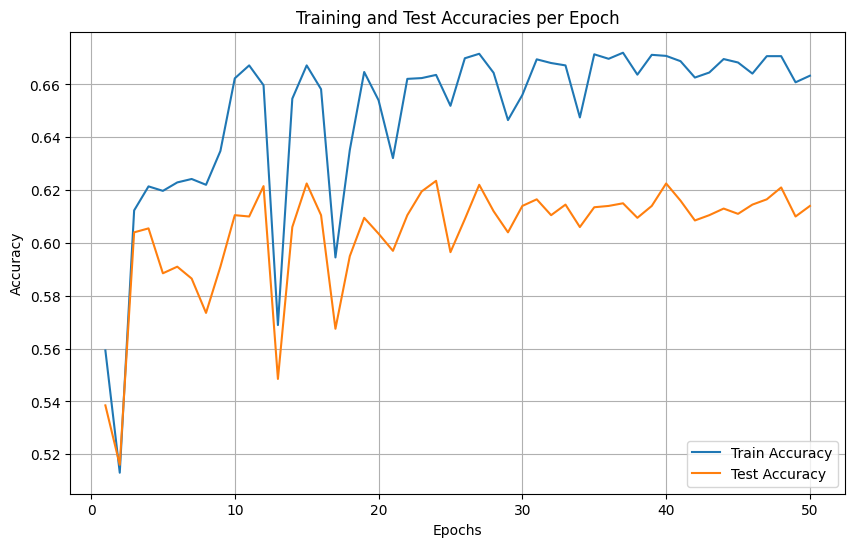

In [9]:
train_accuracies_np = cp.asnumpy(cp.array(train_accuracies))
test_accuracies_np = cp.asnumpy(cp.array(test_accuracies))

epochs = range(1, len(train_accuracies_np) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies_np, label='Train Accuracy')
plt.plot(epochs, test_accuracies_np, label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

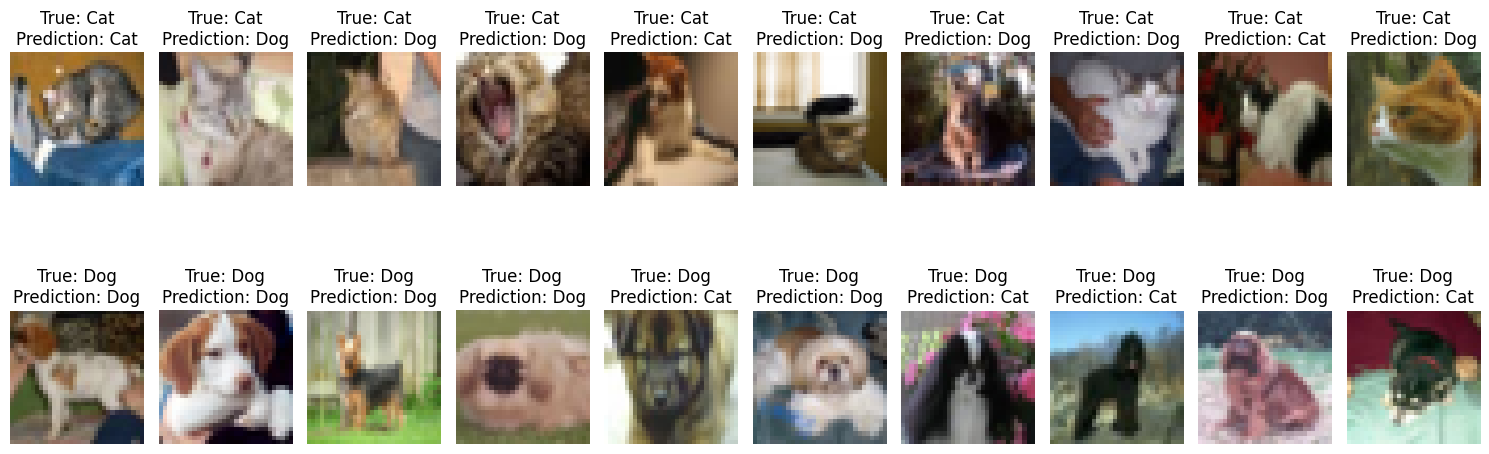

In [ ]:
cat_indices = np.where(y_test_cpu == -1)[0]  
dog_indices = np.where(y_test_cpu == 1)[0]   

# Select the first 10 cats and 10 dogs 
cat_indices = cat_indices[:10]
dog_indices = dog_indices[:10]

# Combine and ensure consistent order (cats followed by dogs)
selected_indices = np.concatenate([cat_indices, dog_indices])

# Get the images, true labels, and predicted labels
sample_images = x_test[selected_indices]
sample_true_labels = y_test_cpu[selected_indices]
sample_pred_labels = y_pred_test_cpu[selected_indices]

# Map labels back to class names
label_map_inv = {1: 'Dog', -1: 'Cat'}
true_label_names = [label_map_inv[label] for label in sample_true_labels]
pred_label_names = [label_map_inv[label] for label in sample_pred_labels]

# Reverse scaling to get original pixel values
sample_images_np = sample_images.get()  # Convert CuPy to NumPy
sample_images_original = scaler.inverse_transform(sample_images_np)

# Plot the images
plt.figure(figsize=(15, 6))
for idx in range(len(selected_indices)):
    plt.subplot(2, len(selected_indices) // 2, idx + 1)
    image = sample_images_original[idx].reshape(32, 32, 3)
    image = np.clip(image, 0, 255).astype('uint8')
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {true_label_names[idx]}\nPrediction: {pred_label_names[idx]}")
plt.tight_layout()
plt.show()
